PassengerId : 탑승객의 고유 아이디  
Survival : 생존여부(0: 사망, 1: 생존)  
Pclass : 등실의 등급(1: 1등급, 2: 2등급, 3: 3등급)  
Name : 이름  
Sex : 성별 - 남자:0, 여자:1
Age : 나이  
Sibsp : 함께 탑승한 형제자매, 아내 남편의 수  
Parch: 함께 탑승한 부모, 자식의 수  
Ticket: 티켓번호  
Fare: 티켓의 요금  
Cabin: 객실번호  
Embarked: 배에 탑승한 위치(C = Cherbourg, Q = Queenstown, S = Southampton)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import LabelEncoder

from sklearn.datasets import load_iris # 샘플 데이터 로딩
from sklearn.model_selection import train_test_split

sns.set_style('darkgrid')
plt.rcParams['axes.unicode_minus'] = False

if os.name == 'nt':
    plt.rcParams['font.family'] = 'Malgun Gothic'

In [2]:
# pip install lightgbm

In [3]:
df_train = pd.read_csv('/content/train.csv')
df_test =pd.read_csv('/content/test.csv')
df_sub = pd.read_csv('/content/submission.csv')

In [4]:
# 다운캐스트 함수 설정 
# 메모리를 효율적으로 사용하기 위해 함수 설정 

def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_df = [df_train, df_test, df_sub]
for df in all_df:
    df = downcast(df)

43.7% compressed
39.6% compressed
79.7% compressed


In [5]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)

In [6]:
df_train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S


In [7]:
df_train.info()
# age, cabin, embarked 에 nan값 존재 확인 요망.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float32
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float32
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float32(2), int16(1), int8(4), object(5)
memory usage: 47.1+ KB


In [8]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693428
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329224


In [9]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693428,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [10]:
# df_train.corr()

In [11]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [12]:
df_train['Sex'] = df_train['Sex'].replace('male',0)
df_train['Sex'] = df_train['Sex'].replace('female',1)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.099998,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.050000,NaN,S


In [13]:
# age, fare, embarked 각각의 nan값 확인
print(df_train['Age'].isnull().sum())
print(df_train['Cabin'].isnull().sum())
print(df_train['Embarked'].isnull().sum())

177
687
2


In [14]:
# embarked 의 nan 수는 적으니, 일단 2개의 데이터를 확인해 보고, 결정 - 아마 지울 듯
df_train[df_train['Embarked'].isnull() == True]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


In [15]:
df_train[df_train['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,NaN


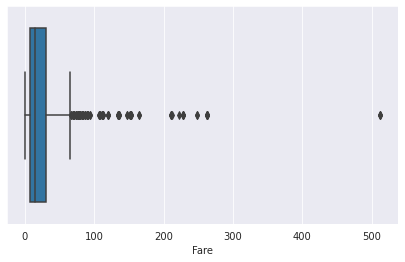

In [16]:
plt.figure(figsize=(7,4))
sns.boxplot(x = df_train.Fare)

In [17]:
df_train[(df_train.Fare >= 70) & (df_train.Fare <= 80) & (df_train.Pclass == 2)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
72,73,0,2,"Hood, Mr. Ambrose Jr",0,21.0,0,0,S.O.C. 14879,73.5,NaN,S
120,121,0,2,"Hickman, Mr. Stanley George",0,21.0,2,0,S.O.C. 14879,73.5,NaN,S
385,386,0,2,"Davies, Mr. Charles Henry",0,18.0,0,0,S.O.C. 14879,73.5,NaN,S
655,656,0,2,"Hickman, Mr. Leonard Mark",0,24.0,2,0,S.O.C. 14879,73.5,NaN,S
665,666,0,2,"Hickman, Mr. Lewis",0,32.0,2,0,S.O.C. 14879,73.5,NaN,S


In [18]:
df_train[(df_train.Fare >= 70) & (df_train.Fare <= 74) & (df_train.Pclass == 1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.283302,C85,C
540,541,1,1,"Crosby, Miss. Harriet R",1,36.0,0,2,WE/P 5735,71.000000,B22,S
745,746,0,1,"Crosby, Capt. Edward Gifford",0,70.0,1,1,WE/P 5735,71.000000,B22,S


In [19]:
df_train[(df_train.Fare >= 10) & (df_train.Fare <= 30) & (df_train.Pclass == 1)]. head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
11,12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.549999,C103,S
30,31,0,1,"Uruchurtu, Don. Manuel E",0,40.0,0,0,PC 17601,27.720800,NaN,C
64,65,0,1,"Stewart, Mr. Albert A",0,NaN,0,0,PC 17605,27.720800,NaN,C
136,137,1,1,"Newsom, Miss. Helen Monypeny",1,19.0,0,2,11752,26.283300,D47,S
168,169,0,1,"Baumann, Mr. John D",0,NaN,0,0,PC 17318,25.924999,NaN,S


Fare 에 따른 객실 등급을 구분짓기엔 모호한 점이 많다. -> Fare에 따른 객실 관계는 거의 없다고 보는 게 맞음

In [20]:
print(df_train['PassengerId'].duplicated().sum())
print(df_train['Name'].duplicated().sum())
print(df_train['Ticket'].duplicated().sum())
print(df_train['Cabin'].duplicated().sum())
print(df_train['Embarked'].duplicated().sum())

# 중복값 없음 -> 하나의 passenger에 따른 중복이 없음.

0
0
210
743
887


In [21]:
# 본론으로 돌아와서 embarked의 nan 2개를 어떻게 할까?
# 2개의 방법이 있음.
# 삭제를 할 것인가? -> 겨우 2개의 데이터
# 다른 값으로 대체할 것인가? -> embarked가 다른 컬럼에 어떤 영향을 받는가에 따라 대체를 할 수 있을지도?

In [22]:
# 대체해 보는 건 어떨까?
df_train.corr()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000


In [23]:
df_train.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [24]:
df_train.Embarked.head(10)

0    S
1    C
2    S
3    S
4    S
5    Q
6    S
7    S
8    S
9    C
Name: Embarked, dtype: object

In [25]:
df_train['Embarked']=LabelEncoder().fit_transform(df_train['Embarked'])
df_train.Embarked.head(10)

# s -> 2
# c -> 0
# Q -> 1

0    2
1    0
2    2
3    2
4    2
5    1
6    2
7    2
8    2
9    0
Name: Embarked, dtype: int64

In [26]:
df_train.Embarked.value_counts()

# nan 은 3으로.

2    644
0    168
1     77
3      2
Name: Embarked, dtype: int64

In [27]:
df_train.corr()

# 요주 컬럼 - Pclass, SibSp, Parch

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,1.000000,-0.005007,-0.035144,-0.042939,0.036847,-0.057527,-0.001652,0.012658,0.013083
Survived,-0.005007,1.000000,-0.338481,0.543351,-0.077221,-0.035322,0.081629,0.257307,-0.163517
Pclass,-0.035144,-0.338481,1.000000,-0.131900,-0.369226,0.083081,0.018443,-0.549500,0.157112
Sex,-0.042939,0.543351,-0.131900,1.000000,-0.093254,0.114631,0.245489,0.182333,-0.104057
Age,0.036847,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,-0.025252
SibSp,-0.057527,-0.035322,0.083081,0.114631,-0.308247,1.000000,0.414838,0.159651,0.066654
Parch,-0.001652,0.081629,0.018443,0.245489,-0.189119,0.414838,1.000000,0.216225,0.038322
Fare,0.012658,0.257307,-0.549500,0.182333,0.096067,0.159651,0.216225,1.000000,-0.221226
Embarked,0.013083,-0.163517,0.157112,-0.104057,-0.025252,0.066654,0.038322,-0.221226,1.000000


In [28]:
df_train[df_train.Embarked == 3]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,3
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,3


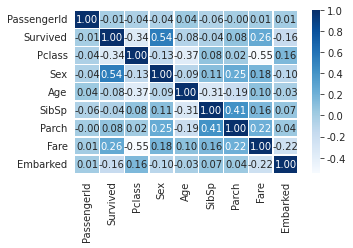

In [29]:
# 해야 할 부분은 embarked가 다른 부분에 영향을 준다면, 다른 부분도 embarked에 영향을 줄 것.
# 그러므로, 서로의 연관성을 파악하여 nan 값을 대체한다.

plt.figure(figsize=(5,3))
sns.heatmap(data = df_train.corr(), annot=True,
           fmt='.2f', linewidth=.5, cmap='Blues')

In [30]:
# 히트맵을 보아하니, 양의 상관관계에 있는 컬럼 중 passengerid, sibsp, parch. pclass 를 뽑으면 무언가를 알아낼 수 있을 거 같음.
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [31]:
df_copy = df_train[['PassengerId','Pclass','SibSp','Parch','Embarked']]
df_copy = df_copy.set_index(['PassengerId'])
df_copy.head()

,Pclass,SibSp,Parch,Embarked
PassengerId,,,,
1,3,1,0,2
2,1,1,0,0
3,3,0,0,2
4,1,1,0,2
5,3,0,0,2


In [32]:
df_copy.SibSp.unique()

array([1, 0, 3, 4, 2, 5, 8], dtype=int8)

In [33]:
df_copy[df_copy['SibSp'] == 8]

# 8명의 자녀 + 부모 있는 대가족은 모두 S에서 배를 탔음.

,Pclass,SibSp,Parch,Embarked
PassengerId,,,,
160,3,8,2,2
181,3,8,2,2
202,3,8,2,2
325,3,8,2,2
793,3,8,2,2
847,3,8,2,2
864,3,8,2,2


In [34]:
df_copy[df_copy['Embarked'] == 2].Pclass.value_counts()

3    353
2    164
1    127
Name: Pclass, dtype: int64

In [35]:
# embarked 가 nan인 2명은 모두 pclass가 1, SibSp가 0, parch가 0

df_copy[(df_copy['Pclass'] == 1) & (df_copy['SibSp'] == 0) & (df_copy['Parch'] == 0)].count()

# nan 과 비슷한 조건을 가진 사람은 총 109명

Pclass      109
SibSp       109
Parch       109
Embarked    109
dtype: int64

In [36]:
df_copy[(df_copy['Pclass'] == 1) & (df_copy['SibSp'] == 0) & (df_copy['Parch'] == 0)].Embarked.value_counts()

# 0 -> c
# 1 -> q
# 2 -> s

# Q는 아예 없으므로, c와 s만 생각하면 되는데,,, 일단 제외시켜 보자. 제외시키고, 양의 상관관계 이외의 컬럼에서 비슷한 조건을 찾아보자

2    66
0    41
3     2
Name: Embarked, dtype: int64

In [37]:
df_copy1 = df_train[(df_train['Pclass'] == 1) & (df_train['SibSp'] == 0) & (df_train['Parch'] == 0) & 
                       (df_train['Embarked'] != 1)]
df_copy1.count()

PassengerId    109
Survived       109
Pclass         109
Name           109
Sex            109
Age             86
SibSp          109
Parch          109
Ticket         109
Fare           109
Cabin           78
Embarked       109
dtype: int64

In [38]:
df_copy1.set_index(['PassengerId'], inplace=True)
df_copy1.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
7,0,1,"McCarthy, Mr. Timothy J",0,54.0,0,0,17463,51.862499,E46,2
12,1,1,"Bonnell, Miss. Elizabeth",1,58.0,0,0,113783,26.549999,C103,2
24,1,1,"Sloper, Mr. William Thompson",0,28.0,0,0,113788,35.500000,A6,2
31,0,1,"Uruchurtu, Don. Manuel E",0,40.0,0,0,PC 17601,27.720800,NaN,0
56,1,1,"Woolner, Mr. Hugh",0,NaN,0,0,19947,35.500000,C52,2


In [39]:
df_copy1 = df_copy1[['Sex','Age','Fare','Embarked']]
df_copy1.head()

,Sex,Age,Fare,Embarked
PassengerId,,,,
7,0,54.0,51.862499,2
12,1,58.0,26.549999,2
24,0,28.0,35.500000,2
31,0,40.0,27.720800,0
56,0,NaN,35.500000,2


In [40]:
df_copy1[df_copy1['Embarked'] == 3]

,Sex,Age,Fare,Embarked
PassengerId,,,,
62,1,38.0,80.0,3
830,1,62.0,80.0,3


In [41]:
df_copy1[(df_copy1['Sex'] == 1)].Embarked.value_counts()

0    18
2    14
3     2
Name: Embarked, dtype: int64

In [42]:
df_train[df_train['Cabin'] == 'B28']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",1,38.0,0,0,113572,80.0,B28,3
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",1,62.0,0,0,113572,80.0,B28,3


In [43]:
df_copy1[(df_copy1['Sex'] == 1) & (df_copy1['Fare'] >= 80.0)].Embarked.value_counts()

0    9
2    8
3    2
Name: Embarked, dtype: int64

In [44]:
# 결론 -> 데이터 삭제가 맞아 보이지만,,, 일단은 0이 가장 많으므로 0으로 대체하는 걸로 해 보자.

In [45]:
df_train['Embarked'].replace(3,0, inplace=True)

In [46]:
df_train['Embarked'].unique()  # nan을 0으로 대체 완료.

array([2, 0, 1])

In [47]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.250000,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.283302,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.925000,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.099998,C123,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.050000,NaN,2


In [48]:
df_train.info()

# Next Step : Age 와 Cabin 의 nan 값을 어떻게 처리할 것인가? 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          714 non-null    float32
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float32
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
dtypes: float32(2), int16(1), int64(2), int8(4), object(3)
memory usage: 47.1+ KB


In [49]:
df_train['Cabin'].isnull().sum()  # 데이터를 삭제하기엔 너무 크고, 다른 값으로 대체하기엔 object라 애매,,,

# 컬럼 삭제 여부를 검토해야 할 것!

687

In [50]:
df_train[df_train['Age'].isnull() == True].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",0,NaN,0,0,330877,8.4583,NaN,1
17,18,1,2,"Williams, Mr. Charles Eugene",0,NaN,0,0,244373,13.0000,NaN,2
19,20,1,3,"Masselmani, Mrs. Fatima",1,NaN,0,0,2649,7.2250,NaN,0
26,27,0,3,"Emir, Mr. Farred Chehab",0,NaN,0,0,2631,7.2250,NaN,0
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",1,NaN,0,0,330959,7.8792,NaN,1


In [51]:
# 위의 featuremap에 따라 양의 상관관계, 0에 가까운 음의 상관관계 컬럼만 보면
# passengerid, survived, sex, fare, embarked

df_copy2 = df_train[['PassengerId','Survived','Sex','Age','Fare','Embarked']]
df_copy2.set_index(['PassengerId'], inplace=True)
df_copy2.head(3)

,Survived,Sex,Age,Fare,Embarked
PassengerId,,,,,
1,0,0,22.0,7.250000,2
2,1,1,38.0,71.283302,0
3,1,1,26.0,7.925000,2


In [52]:
df_copy3 = df_copy2[df_copy2['Age'].isnull() == True]

In [53]:
df_copy3['Survived'].value_counts()

0    125
1     52
Name: Survived, dtype: int64

In [54]:
df_copy3['Sex'].value_counts()

0    124
1     53
Name: Sex, dtype: int64

In [55]:
df_copy3['Fare'].value_counts()

7.750000      20
7.895800      15
8.050000      14
0.000000       8
69.550003      7
7.229200       7
7.225000       6
15.500000      6
25.466700      4
15.245800      3
7.250000       3
24.150000      3
56.495800      3
16.100000      3
7.879200       3
7.829200       2
23.250000      2
52.000000      2
26.549999      2
19.966700      2
7.733300       2
7.550000       2
14.500000      2
14.458300      2
23.450001      2
22.358299      2
7.775000       2
7.737500       2
27.720800      2
8.137500       1
13.862500      1
89.104202      1
15.100000      1
7.629200       1
29.700001      1
221.779205     1
6.950000       1
227.524994     1
30.695801      1
8.712500       1
33.000000      1
42.400002      1
7.050000       1
39.599998      1
30.000000      1
8.458300       1
110.883301     1
7.725000       1
51.862499      1
146.520798     1
21.679199      1
35.500000      1
7.787500       1
7.312500       1
8.662500       1
55.000000      1
25.924999      1
15.050000      1
50.000000     

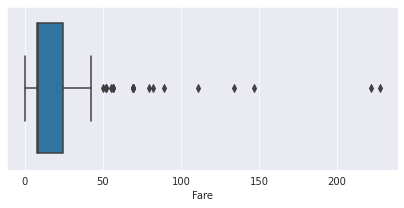

In [56]:
plt.figure(figsize=(7,3))
sns.boxplot(x=df_copy3['Fare'])

In [57]:
for i in df_copy3['Fare'].tolist():
    max_i = []
    max_outer = []
    
    if i >= 50:
        continue
    elif i >= 35:
        max_outer.append(i)
        print(max_outer)
    else:
        max_i.append(i)

# print(max_outer)

[35.5]
[35.0]
[42.400001525878906]
[39.599998474121094]


In [58]:
df_copy3[(df_copy3['Fare'] >= 35) & (df_copy3['Fare'] < 50)]

# whisker : 42

,Survived,Sex,Age,Fare,Embarked
PassengerId,,,,,
56,1,0,NaN,35.500000,2
352,0,0,NaN,35.000000,2
603,0,0,NaN,42.400002,2
767,0,0,NaN,39.599998,0


In [59]:
df_copy3['Embarked'].value_counts()

2    90
1    49
0    38
Name: Embarked, dtype: int64

In [60]:
df_copy3[(df_copy3['Survived'] == 0) & (df_copy3['Sex'] == 0) & (df_copy3['Fare'] <= 43)].Embarked.value_counts()

2    56
1    23
0    20
Name: Embarked, dtype: int64

In [61]:
df_copy4 = df_train[(df_train['Survived'] == 0) & (df_train['Sex'] == 0) & (df_train['Fare'] <= 43)]
df_copy4 = df_copy4[df_copy4['Age'].isnull() != True]
df_copy5 = df_copy4.groupby(['Survived','Sex'])['Age'].mean()
df_copy5.values

array([31.05538], dtype=float32)

In [62]:
# age의 nan값을 31.05538로 대체
df_train['Age'].fillna(value=31.00000, inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    int64  
 5   Age          891 non-null    float32
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float32
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    int64  
dtypes: float32(2), int16(1), int64(2), int8(4), object(3)
memory usage: 47.1+ KB


In [63]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.250000,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.283302,C85,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.925000,NaN,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.099998,C123,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.050000,NaN,2


In [64]:
# 이제 마지막으로 Cabin의 nan을 어떻게 해결할 것인가, 인데.... 혹시 Cabin(위치)에 따른 사망률이 다른가?

In [65]:
df_train[df_train.Cabin.isnull() == False].count()

PassengerId    204
Survived       204
Pclass         204
Name           204
Sex            204
Age            204
SibSp          204
Parch          204
Ticket         204
Fare           204
Cabin          204
Embarked       204
dtype: int64

In [66]:
df_copy6 = df_train[['PassengerId','Survived','Cabin']]
df_copy6.set_index(['PassengerId'], inplace=True)
df_copy6 = df_copy6[df_copy6['Cabin'].isnull() == False]
df_copy6

,Survived,Cabin
PassengerId,,
2,1,C85
4,1,C123
7,0,E46
11,1,G6
12,1,C103
22,1,D56
24,1,A6
28,0,C23 C25 C27
32,1,B78


In [67]:
df_copy6['Survived'].value_counts()

1    136
0     68
Name: Survived, dtype: int64

In [68]:
df_copy7 = df_copy6[df_copy6['Survived'] == 0]

In [69]:
df_copy7['Cabin'].value_counts()

G6             2
C22 C26        2
C23 C25 C27    2
F G73          2
D26            2
C124           2
D50            1
A10            1
C86            1
B38            1
C95            1
D46            1
E58            1
C65            1
C30            1
B37            1
A14            1
D48            1
E46            1
E38            1
B71            1
C68            1
F G63          1
C46            1
B22            1
D30            1
E77            1
F38            1
D6             1
B82 B84        1
A36            1
B102           1
A24            1
E63            1
C82            1
C111           1
C49            1
B30            1
C83            1
E31            1
A5             1
C110           1
B58 B60        1
C123           1
B86            1
F2             1
B19            1
A7             1
A32            1
E44            1
C78            1
C87            1
E67            1
B94            1
C118           1
A19            1
D              1
C91            1
C2            

In [70]:
df_copy7['Cabin'].unique()

array(['E46', 'C23 C25 C27', 'B30', 'C83', 'F G73', 'E31', 'A5', 'D26',
       'C110', 'B58 B60', 'C123', 'B86', 'F2', 'B19', 'A7', 'C49', 'A32',
       'G6', 'C78', 'C87', 'E67', 'B94', 'C118', 'A19', 'D', 'C22 C26',
       'C124', 'C91', 'C2', 'T', 'C128', 'C82', 'E44', 'C111', 'E38',
       'E63', 'A14', 'B37', 'C30', 'C65', 'D46', 'C95', 'B38', 'C86',
       'A10', 'D50', 'D48', 'E58', 'B71', 'C68', 'F G63', 'C46', 'B22',
       'D30', 'E77', 'F38', 'D6', 'B82 B84', 'A36', 'B102', 'A24',
       'B51 B53 B55'], dtype=object)

In [71]:
# plt.figure(figsize=(7,3))
# df_copy7.plot(x='Cabin', y='Survived', kind='scatter')

In [72]:
# Cabin의 nan 값을 제외하고, 204개의 데이터 중에서 살아남지 못한 사람들의 Cabin만 뽑아봤는데, 분포가 제각각임을 파악할 수 있다.
# 이런 경우 NaN 값을 처리하기가 애매함. 대체할 수도 없고 삭제하기엔 너무 큰 데이터 손실을 불러옴.
# 따라서 column 삭제로 결정.

In [73]:
df_train.drop(['Cabin'], axis=1, inplace=True)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.250000,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.283302,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.925000,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.099998,2
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.050000,2


In [74]:
df_train['Age'] = df_train['Age'].map(int)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.283302,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.925000,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2


In [75]:
# full_df 만들기 전에 몇 가지 필요한 시각화

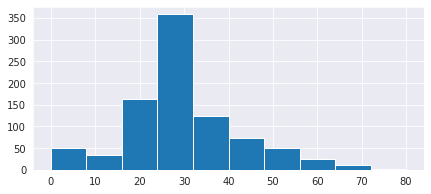

In [76]:
plt.figure(figsize=(7,3))
df_train['Age'].hist()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


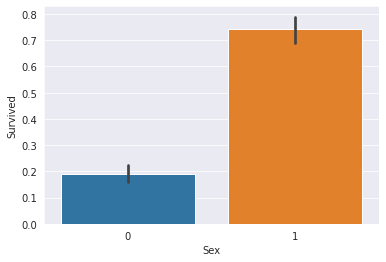

In [77]:
# 성별에 따른 생존 그래프

bar = sns.barplot('Sex', 'Survived', data = df_train)

# 여자가 압도적으로 많이 살았음.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


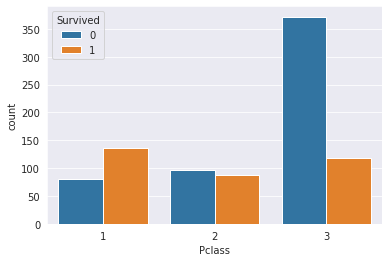

In [78]:
# 객실 등급별 생존 그래프

sns.countplot('Pclass', hue = 'Survived', data = df_train)

# 3등급이 압도적으로 많이 죽음

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


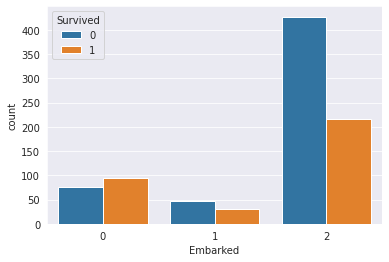

In [79]:
# 승선한 항별 생존자 그래프

sns.countplot('Embarked', hue = 'Survived', data = df_train)

---

여기서부터 full_df 생성 시작

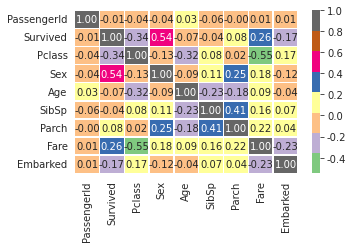

In [80]:
plt.figure(figsize=(5,3))
sns.heatmap(data = df_train.corr(), annot=True,
           fmt='.2f', linewidth=.5, cmap='Accent')

In [81]:
# Survived의 상관관계에 따라 sex, parch, fare의 수치가 높음을 확인.
# 이것을 토대로 column을 추가하면..?

In [82]:
df_train['Fare'] = round(df_train['Fare'], 2)

In [83]:
df_train.Fare

0        7.250000
1       71.279999
2        7.920000
3       53.099998
4        8.050000
5        8.460000
6       51.860001
7       21.080000
8       11.130000
9       30.070000
10      16.700001
11      26.549999
12       8.050000
13      31.280001
14       7.850000
15      16.000000
16      29.120001
17      13.000000
18      18.000000
19       7.220000
20      26.000000
21      13.000000
22       8.030000
23      35.500000
24      21.080000
25      31.389999
26       7.220000
27     263.000000
28       7.880000
29       7.900000
30      27.719999
31     146.520004
32       7.750000
33      10.500000
34      82.169998
35      52.000000
36       7.230000
37       8.050000
38      18.000000
39      11.240000
40       9.480000
41      21.000000
42       7.900000
43      41.580002
44       7.880000
45       8.050000
46      15.500000
47       7.750000
48      21.680000
49      17.799999
50      39.689999
51       7.800000
52      76.730003
53      26.000000
54      61.980000
55      35

In [84]:
# 사람 이름은 passengerid로 구분 짓는다.
g_1 = df_train.groupby(['Sex']).agg({'Survived':['mean']})
g_1

,Survived
,mean
Sex,
0,0.188908
1,0.742038


In [85]:
g_2 = df_train.groupby(['Parch']).agg({'Survived':['mean']})
g_2

,Survived
,mean
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


In [86]:
# g_3 = df_train.groupby(['Fare']).agg({'Survived':['mean']})
# g_3 

In [87]:
g_1.columns = ['Sex_Survived']
g_1.reset_index(inplace = True)

df_train = pd.merge(df_train, g_1, on=['Sex'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908


In [88]:
g_2.columns = ['Parch_Survived']
g_2.reset_index(inplace = True)

df_train = pd.merge(df_train, g_2, on=['Parch'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658


In [89]:
# g_3.columns = ['Fare_Survived']
# g_3.reset_index(inplace = True)

# df_train = pd.merge(df_train, g_3, on=['Fare'], how='left')
# df_train.head()

In [90]:
g_4 = df_train.groupby(['Age']).agg({'Survived':['mean']})
g_4

,Survived
,mean
Age,
0,1.000000
1,0.714286
2,0.300000
3,0.833333
4,0.700000
5,1.000000
6,0.666667
7,0.333333


In [91]:
g_4.columns = ['Age_Survived']
g_4.reset_index(inplace = True)

df_train = pd.merge(df_train, g_4, on=['Age'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111


In [92]:
# 출신에 따른 남녀 비율이 있을까?

In [93]:
df_copy10 = df_train
df_copy10['human_count'] = 1
df_copy10 = df_train.groupby(['Embarked','Sex'])['human_count'].sum()
df_copy10

# 모든 지역에서 남자의 수가 많음. 특히 2에서

Embarked  Sex
0         0       95
          1       75
1         0       41
          1       36
2         0      441
          1      203
Name: human_count, dtype: int64

In [94]:
g_5 = df_train.groupby(['Embarked']).agg({'Survived':['mean']})

g_5.columns = ['Embarked_Survived']
g_5.reset_index(inplace = True)

df_train = pd.merge(df_train, g_5, on=['Embarked'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407,1,0.336957
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545,1,0.558824
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333,1,0.336957
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111,1,0.336957
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111,1,0.336957


In [95]:
g_6 = df_train.groupby(['Pclass']).agg({'Survived':['mean']})

g_6.columns = ['Pclass_Survived']
g_6.reset_index(inplace = True)

df_train = pd.merge(df_train, g_6, on=['Pclass'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407,1,0.336957,0.242363
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545,1,0.558824,0.629630
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333,1,0.336957,0.242363
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111,1,0.336957,0.629630
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111,1,0.336957,0.242363


In [96]:
g_7 = df_train.groupby(['Sex','Parch']).agg({'Survived':['mean']})

g_7.columns = ['Sex_Parch_Survived']
g_7.reset_index(inplace = True)

df_train = pd.merge(df_train, g_7, on=['Sex','Parch'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407,1,0.336957,0.242363,0.165289
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545,1,0.558824,0.629630,0.788660
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333,1,0.336957,0.242363,0.788660
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111,1,0.336957,0.629630,0.788660
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111,1,0.336957,0.242363,0.165289


In [97]:
g_8 = df_train.groupby(['Pclass']).agg({'Fare':['mean']})

g_8.columns = ['Pclass_Fare']
g_8.reset_index(inplace = True)

df_train = pd.merge(df_train, g_8, on=['Pclass'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407,1,0.336957,0.242363,0.165289,13.675906
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545,1,0.558824,0.629630,0.788660,84.154633
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333,1,0.336957,0.242363,0.788660,13.675906
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111,1,0.336957,0.629630,0.788660,84.154633
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111,1,0.336957,0.242363,0.165289,13.675906


In [98]:
g_9 = df_train.groupby(['Sex']).agg({'Fare':['mean']})

g_9.columns = ['Sex_Fare']
g_9.reset_index(inplace = True)

df_train = pd.merge(df_train, g_9, on=['Sex'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,2,0.188908,0.343658,0.407407,1,0.336957,0.242363,0.165289,13.675906,25.524107
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,0,0.742038,0.343658,0.454545,1,0.558824,0.629630,0.788660,84.154633,44.479935
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,2,0.742038,0.343658,0.333333,1,0.336957,0.242363,0.788660,13.675906,44.479935
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,2,0.742038,0.343658,0.611111,1,0.336957,0.629630,0.788660,84.154633,44.479935
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,2,0.188908,0.343658,0.611111,1,0.336957,0.242363,0.165289,13.675906,25.524107


In [99]:
g_10 = df_train.groupby(['Embarked']).agg({'Fare':['mean']})

g_10.columns = ['Embarked_Fare']
g_10.reset_index(inplace = True)

df_train = pd.merge(df_train, g_10, on=['Embarked'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Sex_Survived,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,0.188908,0.343658,0.407407,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,0.742038,0.343658,0.454545,1,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,0.742038,0.343658,0.333333,1,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,0.742038,0.343658,0.611111,1,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,0.188908,0.343658,0.611111,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187


In [100]:
g_11 = df_train.groupby(['Pclass','Sex']).agg({'Fare':['mean']})

g_11.columns = ['Pclass_Sex_Fare']
g_11.reset_index(inplace = True)

df_train = pd.merge(df_train, g_11, on=['Pclass','Sex'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Parch_Survived,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,0.343658,0.407407,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,0.343658,0.454545,1,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648,106.125748
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,0.343658,0.333333,1,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187,16.119097
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,0.343658,0.611111,1,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187,106.125748
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,0.343658,0.611111,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018


In [101]:
g_12 = df_train.groupby(['Pclass','Embarked']).agg({'Fare':['mean']})

g_12.columns = ['Pclass_Embarked_Fare']
g_12.reset_index(inplace = True)

df_train = pd.merge(df_train, g_12, on=['Pclass','Embarked'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_Survived,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,0.407407,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,0.454545,1,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648,106.125748,104.149887
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,0.333333,1,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187,16.119097,14.644703
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,0.611111,1,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187,106.125748,70.365036
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,0.611111,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703


In [102]:
g_13 = df_train.groupby(['Sex','Embarked']).agg({'Fare':['mean']})

g_13.columns = ['Sex_Embarked_Fare']
g_13.reset_index(inplace = True)

df_train = pd.merge(df_train, g_13, on=['Sex','Embarked'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,human_count,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,1,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648,106.125748,104.149887,75.298401
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,1,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187,16.119097,14.644703,38.741184
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,1,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187,106.125748,70.365036,38.741184
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,1,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427


In [103]:
g_14 = df_train.groupby(['Pclass','Sex','Embarked']).agg({'Fare':['mean']})

g_14.columns = ['Pclass_Sex_Embarked_Fare']
g_14.reset_index(inplace = True)

df_train = pd.merge(df_train, g_14, on=['Pclass','Sex','Embarked'], how='left')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427,13.307812
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648,106.125748,104.149887,75.298401,114.056000
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187,16.119097,14.644703,38.741184,18.670568
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187,106.125748,70.365036,38.741184,99.027084
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427,13.307812


In [104]:
df_train.drop(['human_count'], axis=1, inplace=True)

In [105]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.250000,...,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427,13.307812
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.279999,...,0.558824,0.629630,0.788660,84.154633,44.479935,60.189648,106.125748,104.149887,75.298401,114.056000
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.920000,...,0.336957,0.242363,0.788660,13.675906,44.479935,27.080187,16.119097,14.644703,38.741184,18.670568
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.099998,...,0.336957,0.629630,0.788660,84.154633,44.479935,27.080187,106.125748,70.365036,38.741184,99.027084
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.050000,...,0.336957,0.242363,0.165289,13.675906,25.524107,27.080187,12.662018,14.644703,21.712427,13.307812


In [106]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Embarked', 'Sex_Survived', 'Parch_Survived',
       'Age_Survived', 'Embarked_Survived', 'Pclass_Survived',
       'Sex_Parch_Survived', 'Pclass_Fare', 'Sex_Fare', 'Embarked_Fare',
       'Pclass_Sex_Fare', 'Pclass_Embarked_Fare', 'Sex_Embarked_Fare',
       'Pclass_Sex_Embarked_Fare'],
      dtype='object')

In [107]:
full_df = df_train
full_df = downcast(full_df, False)
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int16  
 1   Survived                  891 non-null    int8   
 2   Pclass                    891 non-null    int8   
 3   Name                      891 non-null    object 
 4   Sex                       891 non-null    int8   
 5   Age                       891 non-null    int8   
 6   SibSp                     891 non-null    int8   
 7   Parch                     891 non-null    int8   
 8   Ticket                    891 non-null    object 
 9   Fare                      891 non-null    float32
 10  Embarked                  891 non-null    int8   
 11  Sex_Survived              891 non-null    float32
 12  Parch_Survived            891 non-null    float32
 13  Age_Survived              891 non-null    float32
 14  Embarked_S

In [108]:
# full_df.drop(['Ticket'], axis=1, inplace=True)
full_df.drop(['Name'], axis=1, inplace=True)

In [109]:
full_df.tail(3)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
888,889,0,3,1,31,1,2,W./C. 6607,23.450001,2,...,0.336957,0.242363,0.612245,13.675906,44.479935,27.080187,16.119097,14.644703,38.741184,18.670568
889,890,1,1,0,26,0,0,111369,30.000000,0,...,0.558824,0.629630,0.165289,84.154633,25.524107,60.189648,67.226067,104.149887,48.261684,93.536194
890,891,0,3,0,32,0,0,370376,7.750000,1,...,0.389610,0.242363,0.165289,13.675906,25.524107,13.275714,12.662018,11.183056,13.838293,11.923590


In [110]:
full_df.shape

(891, 23)

In [111]:
# X_train.tail()

In [112]:
# Y_valid.tail()

In [113]:
# brew install libomp

In [114]:
# pip install lightgbm

In [115]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [116]:
df_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [117]:
df_test.drop(['Name','Ticket','Cabin'], axis=1, inplace=True)

In [118]:
df_test['Sex'] = df_test['Sex'].replace('male',0)
df_test['Sex'] = df_test['Sex'].replace('female',1)

In [119]:
df_test['Embarked']=LabelEncoder().fit_transform(df_test['Embarked'])

In [120]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int16  
 1   Pclass       418 non-null    int8   
 2   Sex          418 non-null    int64  
 3   Age          332 non-null    float32
 4   SibSp        418 non-null    int8   
 5   Parch        418 non-null    int8   
 6   Fare         417 non-null    float32
 7   Embarked     418 non-null    int64  
dtypes: float32(2), int16(1), int64(2), int8(3)
memory usage: 12.0 KB


In [121]:
# df_test[df_test['Embarked'] == 2]

In [122]:
df_test['Age'].fillna(value=31.00000, inplace=True)

In [123]:
df_test[df_test['Fare'].isnull() == True]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
152,1044,3,0,60.5,0,0,NaN,2


In [124]:
df_test.groupby(['Pclass'])['Fare'].mean()

Pclass
1    94.280296
2    22.202105
3    12.459678
Name: Fare, dtype: float32

In [125]:
df_test['Fare'].fillna(value=12.459678, inplace=True)

In [126]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int16  
 1   Pclass       418 non-null    int8   
 2   Sex          418 non-null    int64  
 3   Age          418 non-null    float32
 4   SibSp        418 non-null    int8   
 5   Parch        418 non-null    int8   
 6   Fare         418 non-null    float32
 7   Embarked     418 non-null    int64  
dtypes: float32(2), int16(1), int64(2), int8(3)
memory usage: 12.0 KB


In [127]:
df_test['Age'] = df_test['Age'].map(int)

In [128]:
G_1 = df_train.groupby(['Sex']).agg({'Survived':['mean']})
G_2 = df_train.groupby(['Parch']).agg({'Survived':['mean']})
# G_3 = df_train.groupby(['Fare']).agg({'Survived':['mean']})
G_4 = df_train.groupby(['Age']).agg({'Survived':['mean']})
G_5 = df_train.groupby(['Embarked']).agg({'Survived':['mean']})
G_6 = df_train.groupby(['Pclass']).agg({'Survived':['mean']})
G_7 = df_train.groupby(['Sex','Parch']).agg({'Survived':['mean']})
# G_8 = df_train.groupby(['Sex','Fare']).agg({'Survived':['mean']})
# G_9 = df_train.groupby(['Fare','Parch']).agg({'Survived':['mean']})
# G_10 = df_train.groupby(['Sex','Fare','Parch']).agg({'Survived':['mean']})

In [129]:
G_1.columns = ['Sex_Survived']
G_1.reset_index(inplace = True)

df_test = pd.merge(df_test, G_1, on=['Sex'], how='left')

In [130]:
G_2.columns = ['Parch_Survived']
G_2.reset_index(inplace = True)

df_test = pd.merge(df_test, G_2, on=['Parch'], how='left')

In [131]:
# G_3.columns = ['Fare_Survived']
# G_3.reset_index(inplace = True)

# df_test = pd.merge(df_test, G_3, on=['Fare'], how='left')

In [132]:
G_4.columns = ['Age_Survived']
G_4.reset_index(inplace = True)

df_test = pd.merge(df_test, g_4, on=['Age'], how='left')

In [133]:
G_5.columns = ['Embarked_Survived']
G_5.reset_index(inplace = True)

df_test = pd.merge(df_test, G_5, on=['Embarked'], how='left')

In [134]:
# df_test.drop(['Pclass_Survived'], axis=1, inplace=True)

In [135]:
G_6.columns = ['Pclass_Survived']
G_6.reset_index(inplace = True)

df_test = pd.merge(df_test, G_6, on=['Pclass'], how='left')

In [136]:
df_test.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,Age_Survived,Embarked_Survived,Pclass_Survived
0,892,3,0,34,0,0,7.8292,1,0.188908,0.343658,0.375,0.38961,0.242363


In [137]:
G_7.columns = ['Sex_Parch_Survived']
G_7.reset_index(inplace = True)

df_test = pd.merge(df_test, G_7, on=['Sex','Parch'], how='left')

In [138]:
G_8 = df_test.groupby(['Pclass']).agg({'Fare':['mean']})

G_8.columns = ['Pclass_Fare']
G_8.reset_index(inplace = True)

df_test = pd.merge(df_test, G_8, on=['Pclass'], how='left')
# df_train.head()

G_9 = df_test.groupby(['Sex']).agg({'Fare':['mean']})

G_9.columns = ['Sex_Fare']
G_9.reset_index(inplace = True)

df_test = pd.merge(df_test, G_9, on=['Sex'], how='left')
# df_train.head()

G_10 = df_test.groupby(['Embarked']).agg({'Fare':['mean']})

G_10.columns = ['Embarked_Fare']
G_10.reset_index(inplace = True)

df_test = pd.merge(df_test, G_10, on=['Embarked'], how='left')
# df_train.head()

G_11 = df_test.groupby(['Pclass','Sex']).agg({'Fare':['mean']})

G_11.columns = ['Pclass_Sex_Fare']
G_11.reset_index(inplace = True)

df_test = pd.merge(df_test, G_11, on=['Pclass','Sex'], how='left')
# df_train.head()

G_12 = df_test.groupby(['Pclass','Embarked']).agg({'Fare':['mean']})

G_12.columns = ['Pclass_Embarked_Fare']
G_12.reset_index(inplace = True)

df_test = pd.merge(df_test, G_12, on=['Pclass','Embarked'], how='left')
# df_train.head()

G_13 = df_test.groupby(['Sex','Embarked']).agg({'Fare':['mean']})

G_13.columns = ['Sex_Embarked_Fare']
G_13.reset_index(inplace = True)

df_test = pd.merge(df_test, G_13, on=['Sex','Embarked'], how='left')
# df_train.head()

G_14 = df_test.groupby(['Pclass','Sex','Embarked']).agg({'Fare':['mean']})

G_14.columns = ['Pclass_Sex_Embarked_Fare']
G_14.reset_index(inplace = True)

df_test = pd.merge(df_test, G_14, on=['Pclass','Sex','Embarked'], how='left')
# df_train.head()

In [139]:
# G_8.columns = ['Sex_Fare_Survived']
# G_8.reset_index(inplace = True)

# df_test = pd.merge(df_test, G_8, on=['Sex','Fare'], how='left')

In [140]:
# G_9.columns = ['Fare_Parch_Survived']
# G_9.reset_index(inplace = True)

# df_test = pd.merge(df_test, G_9, on=['Fare','Parch'], how='left')

In [141]:
# G_10.columns = ['Sex_Fare_Parch_Survived']
# G_10.reset_index(inplace = True)

# df_test = pd.merge(df_test, G_10, on=['Sex','Fare','Parch'], how='left')

In [142]:
# X_test = df_test

In [143]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int16  
 1   Survived                  891 non-null    int8   
 2   Pclass                    891 non-null    int8   
 3   Sex                       891 non-null    int8   
 4   Age                       891 non-null    int8   
 5   SibSp                     891 non-null    int8   
 6   Parch                     891 non-null    int8   
 7   Ticket                    891 non-null    object 
 8   Fare                      891 non-null    float32
 9   Embarked                  891 non-null    int8   
 10  Sex_Survived              891 non-null    float32
 11  Parch_Survived            891 non-null    float32
 12  Age_Survived              891 non-null    float32
 13  Embarked_Survived         891 non-null    float32
 14  Pclass_Sur

In [144]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               418 non-null    int16  
 1   Pclass                    418 non-null    int8   
 2   Sex                       418 non-null    int64  
 3   Age                       418 non-null    int64  
 4   SibSp                     418 non-null    int8   
 5   Parch                     418 non-null    int8   
 6   Fare                      418 non-null    float32
 7   Embarked                  418 non-null    int64  
 8   Sex_Survived              418 non-null    float64
 9   Parch_Survived            416 non-null    float64
 10  Age_Survived              416 non-null    float64
 11  Embarked_Survived         418 non-null    float64
 12  Pclass_Survived           418 non-null    float64
 13  Sex_Parch_Survived        415 non-null    float64
 14  Pclass_Far

In [145]:
df_test[df_test['Parch'] >= 3]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
24,916,1,1,48,1,3,262.375000,0,0.742038,0.6,...,0.558824,0.629630,0.75,94.280296,49.74770,66.259766,115.591171,110.073509,92.003227,123.895683
69,961,1,1,60,1,4,263.000000,2,0.742038,0.0,...,0.336957,0.629630,0.00,94.280296,49.74770,28.172026,115.591171,76.677505,40.719650,105.737106
132,1024,3,1,31,0,4,25.466700,2,0.742038,0.0,...,0.336957,0.242363,0.00,12.459678,49.74770,28.172026,13.735129,13.902795,40.719650,16.825609
139,1031,3,0,40,1,6,46.900002,2,0.188908,0.0,...,0.336957,0.242363,NaN,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
142,1034,1,0,61,1,3,262.375000,0,0.188908,0.6,...,0.558824,0.629630,0.00,94.280296,27.47123,66.259766,75.586548,110.073509,49.651077,96.251343
174,1066,3,0,40,1,5,31.387501,2,0.188908,0.2,...,0.336957,0.242363,0.00,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
178,1070,2,1,36,0,3,39.000000,2,0.742038,0.6,...,0.336957,0.472826,0.75,22.202105,49.74770,28.172026,26.438749,23.056089,40.719650,25.884615
342,1234,3,0,31,1,9,69.550003,2,0.188908,NaN,...,0.336957,0.242363,NaN,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
365,1257,3,1,31,1,9,69.550003,2,0.742038,NaN,...,0.336957,0.242363,NaN,12.459678,49.74770,28.172026,13.735129,13.902795,40.719650,16.825609


In [146]:
df_test[df_test['Parch_Survived'].isnull() == True]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
342,1234,3,0,31,1,9,69.550003,2,0.188908,NaN,...,0.336957,0.242363,NaN,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
365,1257,3,1,31,1,9,69.550003,2,0.742038,NaN,...,0.336957,0.242363,NaN,12.459678,49.74770,28.172026,13.735129,13.902795,40.719650,16.825609


In [147]:
df_test['Parch_Survived'] = df_test['Parch_Survived'].fillna(value=0.0)

In [148]:
df_test[df_test['Age_Survived'].isnull() == True]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
81,973,1,0,67,1,0,221.779205,2,0.188908,0.343658,...,0.336957,0.62963,0.165289,94.280296,27.47123,28.172026,75.586548,76.677505,22.105043,55.634342
96,988,1,1,76,1,0,78.849998,2,0.742038,0.343658,...,0.336957,0.62963,0.788660,94.280296,49.74770,28.172026,115.591171,76.677505,40.719650,105.737106


In [149]:
# df_test[df_test['Fare_Survived'].isnull() == True]

In [150]:
df_test[df_test['Age'] >= 60]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
2,894,2,0,62,0,0,9.687500,1,0.188908,0.343658,...,0.389610,0.472826,0.165289,22.202105,27.47123,10.957700,20.184654,11.273951,9.357387,11.273951
13,905,2,0,63,1,0,26.000000,2,0.188908,0.343658,...,0.336957,0.472826,0.165289,22.202105,27.47123,28.172026,20.184654,23.056089,22.105043,21.641827
48,940,1,1,60,0,0,76.291702,0,0.742038,0.343658,...,0.558824,0.629630,0.788660,94.280296,49.74770,66.259766,115.591171,110.073509,92.003227,123.895683
69,961,1,1,60,1,4,263.000000,2,0.742038,0.000000,...,0.336957,0.629630,0.000000,94.280296,49.74770,28.172026,115.591171,76.677505,40.719650,105.737106
81,973,1,0,67,1,0,221.779205,2,0.188908,0.343658,...,0.336957,0.629630,0.165289,94.280296,27.47123,28.172026,75.586548,76.677505,22.105043,55.634342
96,988,1,1,76,1,0,78.849998,2,0.742038,0.343658,...,0.336957,0.629630,0.788660,94.280296,49.74770,28.172026,115.591171,76.677505,40.719650,105.737106
114,1006,1,1,63,1,0,221.779205,2,0.742038,0.343658,...,0.336957,0.629630,0.788660,94.280296,49.74770,28.172026,115.591171,76.677505,40.719650,105.737106
142,1034,1,0,61,1,3,262.375000,0,0.188908,0.600000,...,0.558824,0.629630,0.000000,94.280296,27.47123,66.259766,75.586548,110.073509,49.651077,96.251343
152,1044,3,0,60,0,0,12.459678,2,0.188908,0.343658,...,0.336957,0.242363,0.165289,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
179,1071,1,1,64,0,2,83.158302,0,0.742038,0.500000,...,0.558824,0.629630,0.612245,94.280296,49.74770,66.259766,115.591171,110.073509,92.003227,123.895683


In [151]:
df_test['Age_Survived'] = df_test['Age_Survived'].fillna(value=0.0)

In [152]:
df_test[df_test['Sex_Parch_Survived'].isnull() == True]

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Sex_Survived,Parch_Survived,...,Embarked_Survived,Pclass_Survived,Sex_Parch_Survived,Pclass_Fare,Sex_Fare,Embarked_Fare,Pclass_Sex_Fare,Pclass_Embarked_Fare,Sex_Embarked_Fare,Pclass_Sex_Embarked_Fare
139,1031,3,0,40,1,6,46.900002,2,0.188908,0.0,...,0.336957,0.242363,NaN,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
342,1234,3,0,31,1,9,69.550003,2,0.188908,0.0,...,0.336957,0.242363,NaN,12.459678,27.47123,28.172026,11.830688,13.902795,22.105043,12.716306
365,1257,3,1,31,1,9,69.550003,2,0.742038,0.0,...,0.336957,0.242363,NaN,12.459678,49.74770,28.172026,13.735129,13.902795,40.719650,16.825609


In [153]:
df_test['Sex_Parch_Survived'] = df_test['Sex_Parch_Survived'].fillna(value=0.0)

In [154]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 0 to 417
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               418 non-null    int16  
 1   Pclass                    418 non-null    int8   
 2   Sex                       418 non-null    int64  
 3   Age                       418 non-null    int64  
 4   SibSp                     418 non-null    int8   
 5   Parch                     418 non-null    int8   
 6   Fare                      418 non-null    float32
 7   Embarked                  418 non-null    int64  
 8   Sex_Survived              418 non-null    float64
 9   Parch_Survived            418 non-null    float64
 10  Age_Survived              418 non-null    float64
 11  Embarked_Survived         418 non-null    float64
 12  Pclass_Survived           418 non-null    float64
 13  Sex_Parch_Survived        418 non-null    float64
 14  Pclass_Far

In [155]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 890
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PassengerId               891 non-null    int16  
 1   Survived                  891 non-null    int8   
 2   Pclass                    891 non-null    int8   
 3   Sex                       891 non-null    int8   
 4   Age                       891 non-null    int8   
 5   SibSp                     891 non-null    int8   
 6   Parch                     891 non-null    int8   
 7   Ticket                    891 non-null    object 
 8   Fare                      891 non-null    float32
 9   Embarked                  891 non-null    int8   
 10  Sex_Survived              891 non-null    float32
 11  Parch_Survived            891 non-null    float32
 12  Age_Survived              891 non-null    float32
 13  Embarked_Survived         891 non-null    float32
 14  Pclass_Sur

In [156]:
full_df.drop(['Ticket'], axis=1, inplace=True)

In [157]:
# Train data
X_train = full_df[full_df['PassengerId'] <= 630]
X_train = X_train.drop(['Survived'], axis=1)
Y_train = full_df[full_df['PassengerId'] <= 630]['Survived']
X_valid = full_df[full_df['PassengerId'] > 630]
X_valid = X_valid.drop(['Survived'], axis=1)
Y_valid = full_df[full_df['PassengerId'] > 630]['Survived']

In [158]:
import lightgbm as lgb

# lgb hyper-parameters
params = {'metric': 'rmse',                # evaluated set의 evaluate metric, rmse 사용
          'num_leaves': 255,               # 전체 트리의 잎 수 , 기본값 31개
          'learning_rate': 0.005,          # 각 트리가 최종 결과에 미치는 영향을 결정
          'feature_fraction': 0.75,        # 부스팅이 랜덤 포레스트일 때 사용 반복하여 75% 파라미터를 무작위로 선택하여 트리생성
          'bagging_fraction': 0.75,        # 각 반복에 사용할 데이터의 비율을 지정하여 traing 속도를 높이고 과적합 방지
          'bagging_freq': 5,               # 과적합 방지에 사용
          'force_col_wise' : True,         # 불안정성 방지를 위해 설정 column 값이 크거나 total number of bins가 클 경우 사용
          'random_state': 10}              # 랜덤 시드 고정값

cat_features = ['PassengerId', 'Sex', 'Parch', 'Fare']

# lgb train and valid dataset
dtrain = lgb.Dataset(X_train, Y_train)
dvalid = lgb.Dataset(X_valid, Y_valid)
 
# Train LightGBM model
lgb_model = lgb.train(params=params,
                      train_set=dtrain,
                      num_boost_round=1500,
                      valid_sets=(dtrain, dvalid),
                      early_stopping_rounds=150,
                      categorical_feature=cat_features,
                      verbose_eval=100)   

/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:1208: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Fare', 'Parch', 'PassengerId', 'Sex']
  warnings.warn('categorical_feature in Dataset is overridden.\n'
/usr/local/lib/python3.8/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 150 rounds.
[100]	training's rmse: 0.406589	valid_1's rmse: 0.409859
[200]	training's rmse: 0.368203	valid_1's rmse: 0.378879
[300]	training's rmse: 0.348376	valid_1's rmse: 0.362426
[400]	training's rmse: 0.335567	valid_1's rmse: 0.354894
[500]	training's rmse: 0.32614	valid_1's rmse: 0.349862
[600]	training's rmse: 0.318966	valid_1's rmse: 0.347191
[700]	training's rmse: 0.312679	valid_1's rmse: 0.346792
[800]	training's rmse: 0.307615	valid_1's rmse: 0.347274
Early stopping, best iteration is:
[735]	training's rmse: 0.311096	valid_1's rmse: 0.34659


In [159]:
preds = lgb_model.predict(df_test).clip(0,20)

In [160]:
preds = np.round(preds,0)
preds = preds.astype(int)
preds

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [162]:
df_sub['Survived'] = preds
df_sub.to_csv('submission-6.csv', index=False)